# Question 2 Report: Clustering Analysis of Weather Data with K-means Algorithm 

## 1- Loading of the Data Set and Initial Examination


In [3]:
import pandas as pd

file_path = "weather_forecast_data.csv"
weather_data = pd.read_csv(file_path)

weather_data.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


## 2- General Information of the Data Set

In [6]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2500 non-null   float64
 1   Humidity     2500 non-null   float64
 2   Wind_Speed   2500 non-null   float64
 3   Cloud_Cover  2500 non-null   float64
 4   Pressure     2500 non-null   float64
 5   Rain         2500 non-null   object 
dtypes: float64(5), object(1)
memory usage: 117.3+ KB


## 3- Data Preprocessing - Categorical Variable Conversion and Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

weather_data['Rain'] = weather_data['Rain'].map({'rain': 1, 'no rain': 0})

scaler = StandardScaler()
scaled_data = scaler.fit_transform(weather_data)

scaled_data_df = pd.DataFrame(scaled_data, columns=weather_data.columns)
scaled_data_df.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,0.155431,1.265393,-0.444814,0.028972,0.894714,2.638519
1,0.723225,-0.895074,-0.684143,-1.534074,-1.074570,-0.379000
2,0.339547,0.938599,-1.476731,-1.195246,-0.350663,-0.379000
3,0.142018,0.502270,-0.494138,0.604355,-1.568924,2.638519
4,-0.271701,1.629599,-0.910571,-0.068058,-1.658406,-0.379000


## 4- Determining the Number of Clusters - the Elbow Method

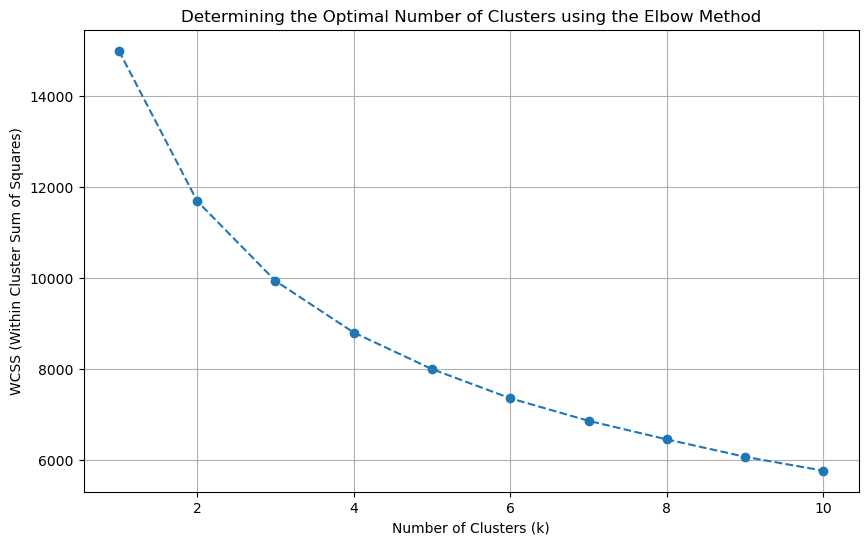

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Determining the Optimal Number of Clusters using the Elbow Method')
plt.grid()
plt.show()

## 5- K-means Clustering Application

In [15]:
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(scaled_data)

weather_data['Cluster'] = kmeans.labels_

weather_data['Cluster'].value_counts()

Cluster
0    780
1    711
2    695
3    314
Name: count, dtype: int64

## 6- Visualization of Clusters - Size Reduction with PCA

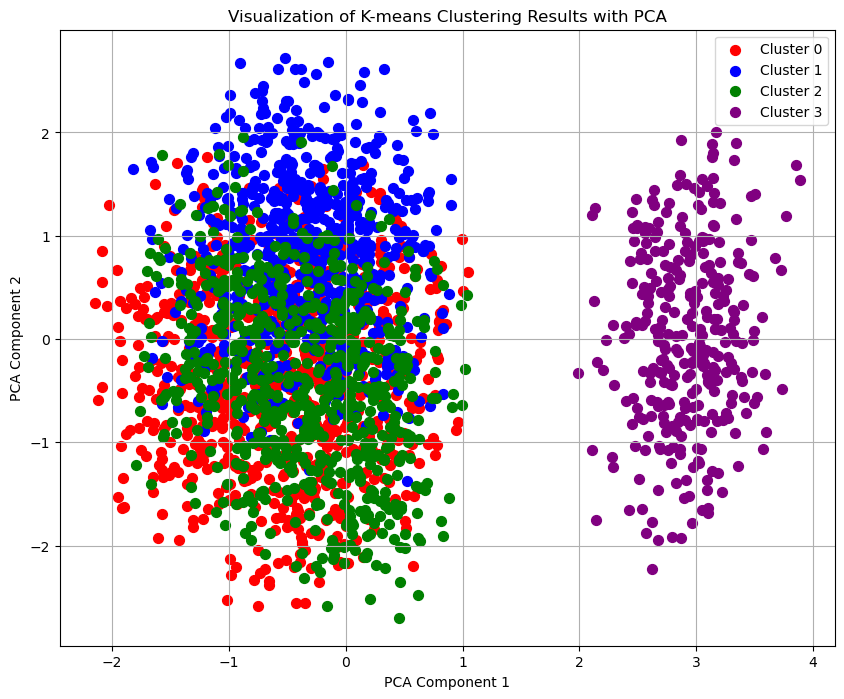

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'purple']
for i in range(k):
    clustered_data = pca_df[pca_df['Cluster'] == i]
    plt.scatter(clustered_data['PCA1'], clustered_data['PCA2'], s=50, c=colors[i], label=f'Cluster {i}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualization of K-means Clustering Results with PCA')
plt.legend()
plt.grid()
plt.show()

## 7- Evaluation of Clustering Quality

In [21]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.19


## 8- Hyperparameter Adjustment - Randomized Search

In [24]:
from sklearn.model_selection import ParameterSampler

param_dist = {
    'n_clusters': [3, 4, 5],
    'init': ['k-means++'],
    'max_iter': [200, 300],
    'n_init': [10]
}

n_iter_search = 5
best_model = None
best_silhouette_score = -1

for params in ParameterSampler(param_dist, n_iter_search, random_state=42):
    kmeans = KMeans(**params, random_state=42)
    kmeans.fit(scaled_data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(scaled_data, labels)
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_model = kmeans
        best_params = params

print(f'The Best Parameters: {best_params}')
print(f'The Highest Silhouette Score: {best_silhouette_score:.2f}')

The Best Parameters: {'n_init': 10, 'n_clusters': 3, 'max_iter': 200, 'init': 'k-means++'}
The Highest Silhouette Score: 0.20


## 9- Investigation of the Properties of Clusters - Boxplot Visualizations

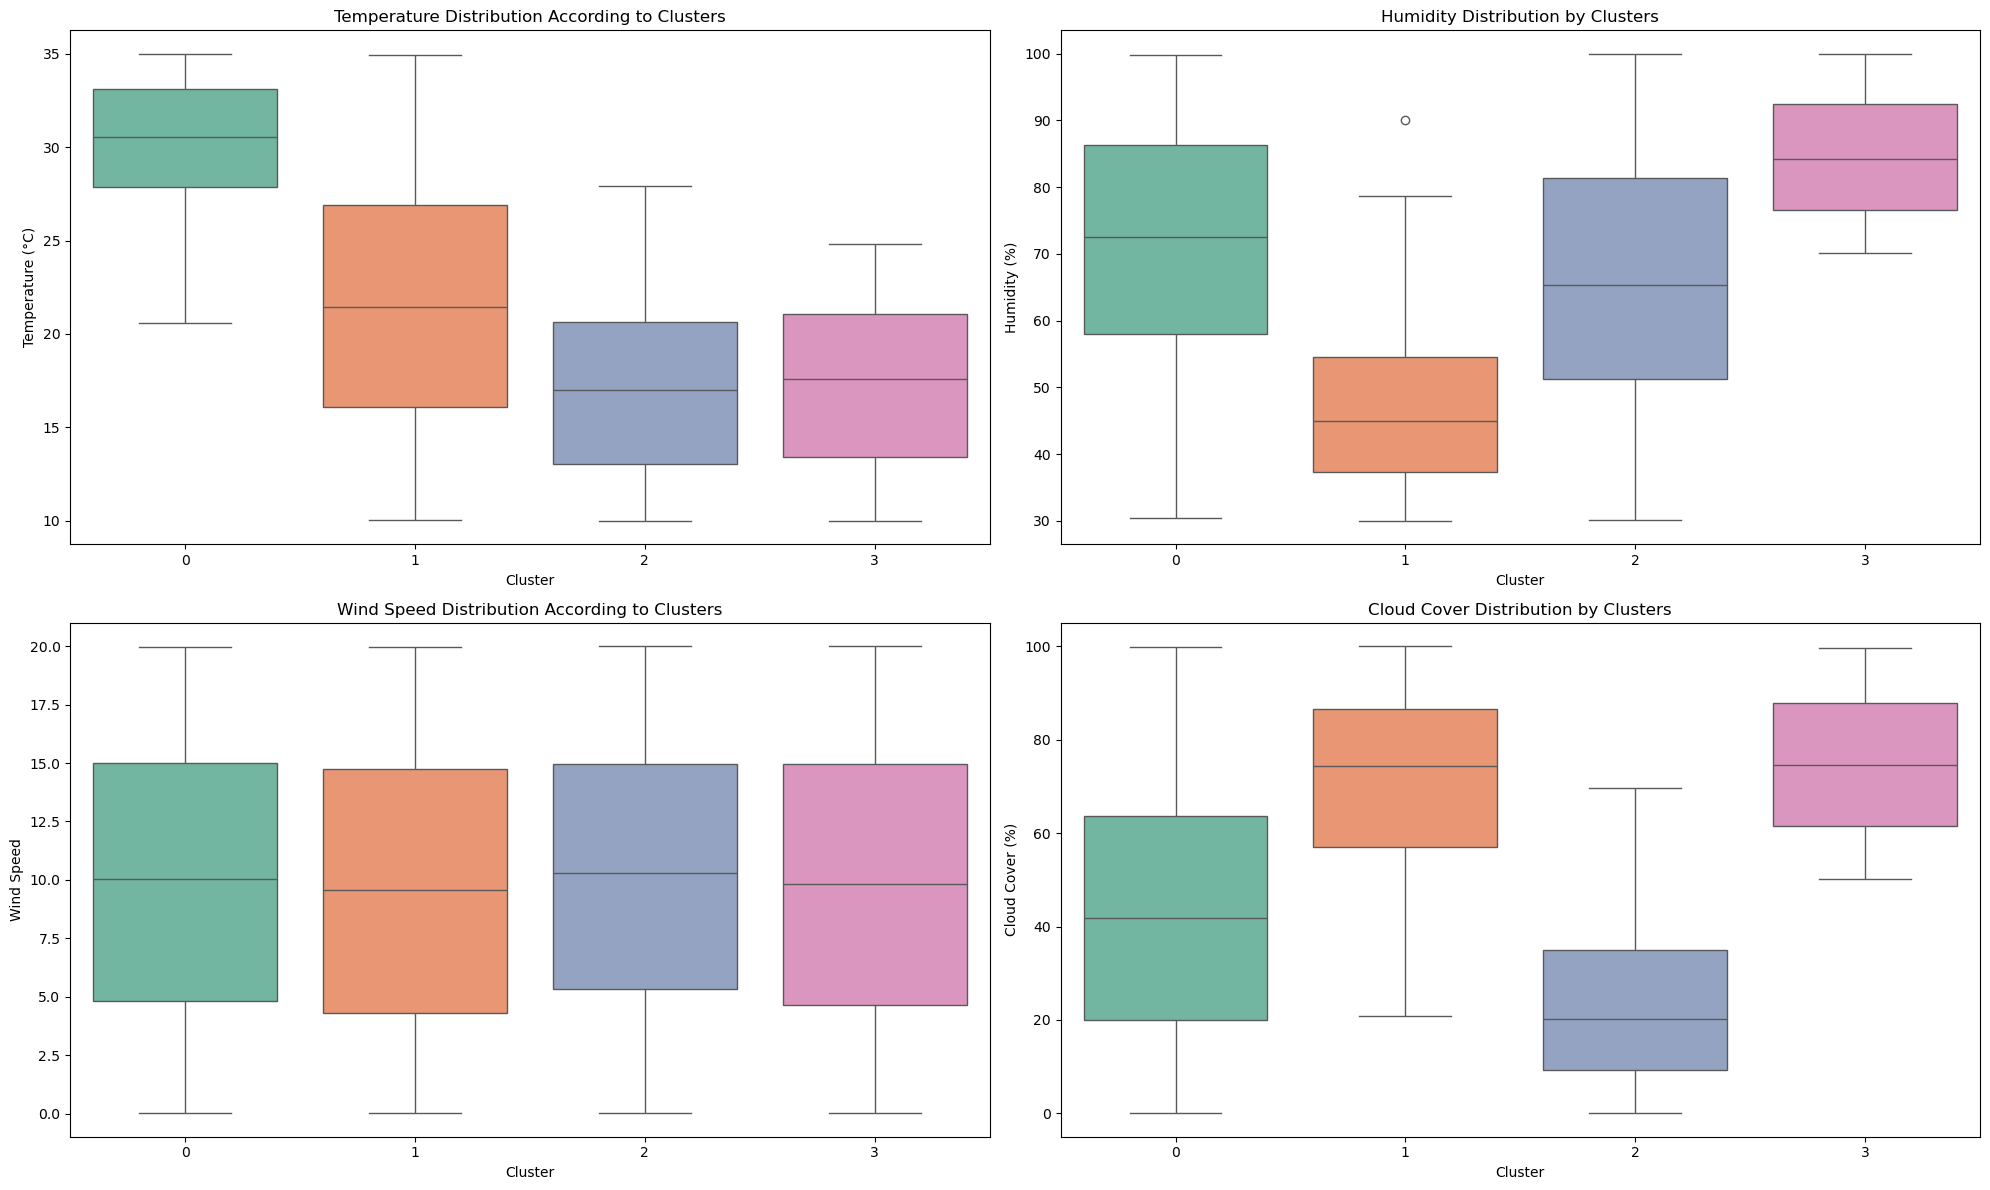

In [27]:
import seaborn as sns

plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
sns.boxplot(x='Cluster', y='Temperature', data=weather_data, hue='Cluster', palette='Set2', legend=False)
plt.title('Temperature Distribution According to Clusters')
plt.xlabel('Cluster')
plt.ylabel('Temperature (°C)')

plt.subplot(2, 2, 2)
sns.boxplot(x='Cluster', y='Humidity', data=weather_data, hue='Cluster', palette='Set2', legend=False)
plt.title('Humidity Distribution by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Humidity (%)')

plt.subplot(2, 2, 3)
sns.boxplot(x='Cluster', y='Wind_Speed', data=weather_data, hue='Cluster', palette='Set2', legend=False)
plt.title('Wind Speed Distribution According to Clusters')
plt.xlabel('Cluster')
plt.ylabel('Wind Speed')

plt.subplot(2, 2, 4)
sns.boxplot(x='Cluster', y='Cloud_Cover', data=weather_data, hue='Cluster', palette='Set2', legend=False)
plt.title('Cloud Cover Distribution by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Cloud Cover (%)')

plt.tight_layout()
plt.show()